<a href="https://colab.research.google.com/github/dksifoua/Optical-Character-Recognition/blob/main/Optical%20Character%20Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Oct 20 18:04:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import cv2
import tqdm
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [3]:
SEED = 456
random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
%%time
!mkdir -p ./data

!wget --no-check-certificate \
    http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz \
    -O ./data/EnglishImg.tgz
!tar zxf ./data/EnglishImg.tgz -C ./data/
!rm ./data/EnglishImg.tgz

!wget --no-check-certificate \
    http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishHnd.tgz \
    -O ./data/EnglishHnd.tgz
!tar zxf ./data/EnglishHnd.tgz -C ./data/
!rm ./data/EnglishHnd.tgz

!wget --no-check-certificate \
    http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz \
    -O ./data/EnglishFnt.tgz
!tar zxf ./data/EnglishFnt.tgz -C ./data/
!rm ./data/EnglishFnt.tgz

!wget --no-check-certificate \
    http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/Lists.tgz \
    -O ./data/Lists.tgz
!tar zxf ./data/Lists.tgz -C ./data/
!rm ./data/Lists.tgz

--2020-10-20 18:04:59--  http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz
Resolving www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)... 131.227.80.48
Connecting to www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)|131.227.80.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133975105 (128M) [application/x-gzip]
Saving to: ‘./data/EnglishImg.tgz’

./data/EnglishImg.t 100%[===================>] 127.77M  3.53MB/s    in 36s     

2020-10-20 18:05:35 (3.58 MB/s) - ‘./data/EnglishImg.tgz’ saved [133975105/133975105]

--2020-10-20 18:05:38--  http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishHnd.tgz
Resolving www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)... 131.227.80.48
Connecting to www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)|131.227.80.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13596287 (13M) [application/x-gzip]
Saving to: ‘./data/EnglishHnd.tgz’

./data/EnglishHnd.t 100%[===================>]  12.97M  4.52MB/s    in 2.9s    

2020-

In [5]:
LABELS = [f'{c}' for c in range(10)] \
    + [chr(c) for c in range(ord('A'), ord('Z') + 1)] \
    + [chr(c) for c in range(ord('a'), ord('z') + 1)]

In [6]:
data, labels = [], []
for directory in tqdm.tqdm(os.listdir('./data/English/Fnt/')):
    label = int(directory[-3:]) - 1
    sub_directory = os.path.join('./data/English/Fnt/', directory)
    for filename in os.listdir(sub_directory):
        path = os.path.join(sub_directory, filename)
        image = tf.keras.preprocessing.image.load_img(path, color_mode='grayscale')
        image = tf.keras.preprocessing.image.img_to_array(image)
        data.append(image); labels.append(label)
data = np.stack(data); labels = np.stack(labels)
print(f'data shape: {data.shape}'); print(f'labels shape: {labels.shape}')

100%|██████████| 62/62 [00:19<00:00,  3.25it/s]


data shape: (62992, 128, 128, 1)
labels shape: (62992,)


In [7]:
assert (np.unique(labels) == np.arange(len(LABELS))).sum() == len(LABELS)

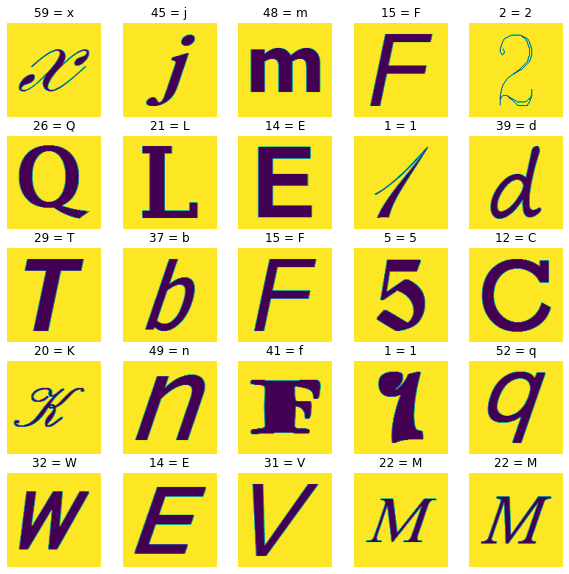

In [8]:
plt.figure(figsize=(10, 10))
for i, index in enumerate(np.random.choice(data.shape[0], size=25, replace=False)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(data[index, :, :, 0])
    plt.title(f'{labels[index]} = {LABELS[labels[index]]}')
    plt.axis('off')
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=SEED)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(LABELS))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(LABELS))
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (56692, 128, 128, 1)
y_train shape: (56692, 62)
X_test shape: (6300, 128, 128, 1)
y_test shape: (6300, 62)


In [10]:
# Free up the RAM
del data
del labels

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda image: (image / 255.0) - 0.5, input_shape=(128, 128, 1)), # Normalization
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='valid', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='valid', activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='valid', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='valid', activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='valid', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='valid', activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(LABELS), activation=tf.nn.softmax)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        3

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.9, min_lr=0.00001)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_reduction])

Epoch 1/100
443/443 [==============================] - 69s 157ms/step - loss: 1.2930 - accuracy: 0.6495 - val_loss: 0.5253 - val_accuracy: 0.8306
Epoch 2/100
443/443 [==============================] - 71s 160ms/step - loss: 0.5212 - accuracy: 0.8276 - val_loss: 0.3776 - val_accuracy: 0.8613
Epoch 3/100
443/443 [==============================] - 70s 159ms/step - loss: 0.4161 - accuracy: 0.8533 - val_loss: 0.3456 - val_accuracy: 0.8694
Epoch 4/100
443/443 [==============================] - 70s 157ms/step - loss: 0.3683 - accuracy: 0.8670 - val_loss: 0.3312 - val_accuracy: 0.8806
Epoch 5/100
443/443 [==============================] - 70s 157ms/step - loss: 0.3403 - accuracy: 0.8763 - val_loss: 0.3276 - val_accuracy: 0.8848
Epoch 6/100
443/443 [==============================] - 69s 157ms/step - loss: 0.3263 - accuracy: 0.8820 - val_loss: 0.2858 - val_accuracy: 0.8875
Epoch 7/100
443/443 [==============================] - 70s 157ms/step - loss: 0.3225 - accuracy: 0.8834 - val_loss: 0.3232 -

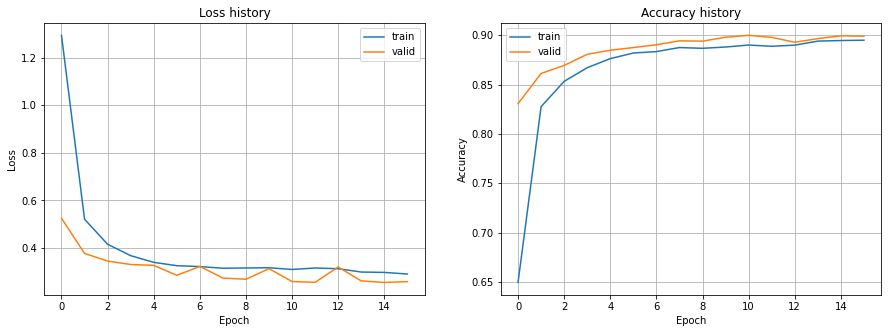

In [15]:
_, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(history.history['loss'], label='train')
axes[0].plot(history.history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()
axes[1].plot(history.history['accuracy'], label='train')
axes[1].plot(history.history['val_accuracy'], label='valid')
axes[1].set_title('Accuracy history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].legend()
plt.show()

In [16]:
!mkdir -p ./checkpoints
model.save('./checkpoints/model.h5')

In [17]:
!wget https://raw.githubusercontent.com/abhinandanarya06/OCR/master/sample_test_image/1.jpg

--2020-10-20 18:31:33--  https://raw.githubusercontent.com/abhinandanarya06/OCR/master/sample_test_image/1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2325637 (2.2M) [image/jpeg]
Saving to: ‘1.jpg’

1.jpg               100%[===================>]   2.22M  --.-KB/s    in 0.1s    

2020-10-20 18:31:34 (18.4 MB/s) - ‘1.jpg’ saved [2325637/2325637]



In [31]:
image = cv2.imread('./1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.medianBlur(image, 5)
image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 41, 10)
contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
predictions = []
for contour in tqdm.tqdm(contours):
    x, y, w, h = cv2.boundingRect(contour)
    box = image[y:y + h, x:x + w]
    box = cv2.resize(box, (128, 128), interpolation=cv2.INTER_AREA)
    box = box.reshape((1, 128, 128, 1))
    pred = model.predict(box).argmax()
    predictions.append(LABELS[pred])

100%|██████████| 2034/2034 [01:07<00:00, 30.09it/s]


In [32]:
' '.join(predictions)

'I I I V I V J I u w N V v t h J o v e T T N e T D J u o J e L I u e I s e T s s J a T e T e T s a L 5 e T r e T F a L s G r n a J o J J v u m u w u u T T w D a L s u o J e T T a I A J c T n u T s e T r a J W H J U J s J o J a J P I u w o J J v F u u v m u w u e I u e I T n e T e T e I J J e I n a L T e T s d T s a J e I T u a I e T e I D J 3 t n T M t o J n c o n n n F V H d u n w u a L T e T h c s J n e T a J s s e I e T T A J a J 2 t u c u r t c o r o n v v 4 w d u J u J a L u T T a L s a l e T h A J n r c s e T e J n a I c 1 o J J G u v h v o J o J o o J o I u J u e T u u J u s u s n r r a L u w u J q u u c c o J e T T T u e T c n s n e I v e T T e L a u e T W e T e I s n a L r e T v e T s T e J u T e T v D J n a J s T K o J s o J y t r t t t o J n n o J t o V v e T u u J T e T n J e I s a J c u n W A J n u e I e T T n a L s a L e T s a I s J J a L e T c u T U u D J J J e T o J t t o J t r n q e J o v J u J n F v u V T s e J A J n a L A J u u s e T u u H W s J T U J T n s e T v e T

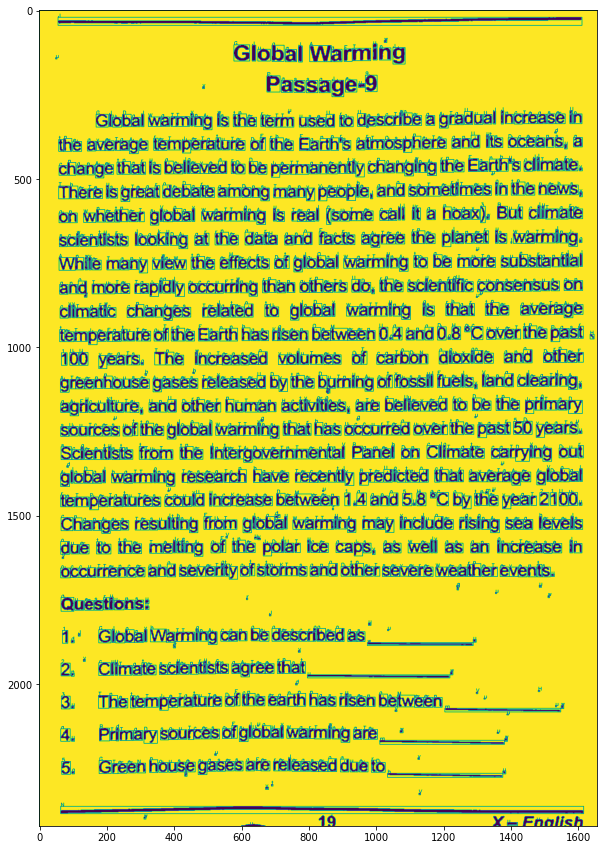

In [28]:
print(image.shape)
plt.figure(figsize=(15, 15))
plt.imshow(image, cmap='gray')
plt.show()